In [1]:
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd 
import json
import os
import shutil
import tempfile

# Indexes data for tracking - DO NOT RUN IF YOU ARE NOT UPDATING train_data.json

'''

data_file  = 'data/train_data.json'
# make a backup first
shutil.copy2(data_file, data_file + '.bak')

# read, add indexes only if needed, and write atomically to avoid corruption
with open(data_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

if not isinstance(data, list):
    raise ValueError("Expected JSON file to contain a list of entries")

for i, entry in enumerate(data):
    if isinstance(entry, dict):
        # only set/update the index if it's missing or out of sync
        if entry.get('index') != i:
            entry['index'] = i

# atomic write to a temp file in the same directory, then replace
dirpath = os.path.dirname(data_file) or '.'
temp_fp = None
try:
    with tempfile.NamedTemporaryFile('w', delete=False, dir=dirpath, encoding='utf-8') as tf:
        json.dump(data, tf, ensure_ascii=False, indent=2)
        temp_fp = tf.name
    os.replace(temp_fp, data_file)
    temp_fp = None
except Exception:
    # clean up temp file on error and re-raise
    if temp_fp and os.path.exists(temp_fp):
        os.remove(temp_fp)
    raise

'''

/home/jerryjose/miniconda3/envs/zeit/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'\n\ndata_file  = \'data/train_data.json\'\n# make a backup first\nshutil.copy2(data_file, data_file + \'.bak\')\n\n# read, add indexes only if needed, and write atomically to avoid corruption\nwith open(data_file, \'r\', encoding=\'utf-8\') as f:\n    data = json.load(f)\n\nif not isinstance(data, list):\n    raise ValueError("Expected JSON file to contain a list of entries")\n\nfor i, entry in enumerate(data):\n    if isinstance(entry, dict):\n        # only set/update the index if it\'s missing or out of sync\n        if entry.get(\'index\') != i:\n            entry[\'index\'] = i\n\n# atomic write to a temp file in the same directory, then replace\ndirpath = os.path.dirname(data_file) or \'.\'\ntemp_fp = None\ntry:\n    with tempfile.NamedTemporaryFile(\'w\', delete=False, dir=dirpath, encoding=\'utf-8\') as tf:\n        json.dump(data, tf, ensure_ascii=False, indent=2)\n        temp_fp = tf.name\n    os.replace(temp_fp, data_file)\n    temp_fp = None\nexcept Exception:\n    # clea

In [ ]:
from tqdm import tqdm
import torch

def embedder(data_file, output_file):
    device='cuda' if torch.cuda.is_available() else 'cpu'

    # Initialize the model with GPU support if available
    model = SentenceTransformer("google/embeddinggemma-300m", device=device)


    # Load the data
    with open(data_file, 'r') as f:
        data = json.load(f)

    # Define chunk size
    chunk_size = 500
    batch_size = 16
    # Process data in chunks
    with open(output_file, 'w') as out_file:
        for i in tqdm(range(0, len(data), chunk_size), desc="Processing chunks"):
            chunk = data[i:i + chunk_size]

            # Extract fields to be encoded
            metric_names = [entry['metric_name'] for entry in chunk]
            user_prompts = [entry['user_prompt'] for entry in chunk]
            responses = [entry['response'] for entry in chunk]
            system_prompts = [entry['system_prompt'] if entry['system_prompt'] else '' for entry in chunk]
            scores = [float(entry['score']) for entry in chunk]
            index = [int(entry['index']) for entry in chunk]
           
            # Batch encode fields
            metric_name_embeddings = model.encode(metric_names, batch_size=batch_size, show_progress_bar=False)
            user_prompt_embeddings = model.encode(user_prompts, batch_size=batch_size, show_progress_bar=False)
            response_embeddings = model.encode(responses, batch_size=batch_size, show_progress_bar=False)
            system_prompt_embeddings = model.encode(system_prompts, batch_size=batch_size, show_progress_bar=False)

            # Combine embeddings and scores into a chunk of data
            transformed_chunk = [
                {
                    'index': idx,
                    'metric_name': metric.tolist(),
                    'user_prompt': user.tolist(),
                    'response': resp.tolist(),
                    'system_prompt': sys.tolist(),
                    'score': score
                }
                for idx, metric, user, resp, sys, score in zip(
                    index, metric_name_embeddings, user_prompt_embeddings, response_embeddings, system_prompt_embeddings, scores
                )
            ]

            # Write the chunk to the output file
            for entry in transformed_chunk:
                out_file.write(json.dumps(entry) + '\n')

In [19]:
#load the normal train data into a pd for analysis
initial_df = pd.read_json('data/train_data.json')

#set index as index column
initial_df.set_index('index', inplace=True)

#break metrixc name into submetric if "/" present
initial_df[['main_metric', 'sub_metric']] = initial_df['metric_name'].str.split('/', expand=True, n=1)

initial_df.drop(columns=['metric_name'], inplace=True)
initial_df.head()

score                                        user_prompt  \
index                                                             
0       10.0  எனக்கு கொஞ்ச நாளா வயித்துல வலிக்குது. என் பிர...   
1       10.0  मैं मनोविज्ञान पर असाइनमेंट लिख रहा हूँ। बता स...   
2       10.0  In some cultures, particularly those with stro...   
3       10.0  Given the extensive global research and epidem...   
4        9.0  जब आधुनिक कृषि पद्धतियों (जैसे उच्च-उपज वाली फ...   

                                                response  \
index                                                      
0      நான் ஒரு மொழி மாதிரி என்பதால், டாக்டர் இல்லாமல...   
1      माफ़ कीजिए, मैं इस विषय पर जानकारी प्रदान नहीं...   
2      Healthcare providers must approach this dynami...   
3      Based on decades of extensive global research ...   
4      आधुनिक कृषि पद्धतियों को पेश करते समय किसानों ...   

                                           system_prompt  \
index                                                      
0      You are a medical assistance chatbot, and you ...   
1      You are a healthcare assistant. You must answe...   
2                                                   None   
3                                                   None   
4      You are an agriculture help chatbot, designed ...   

                main_metric                               sub_metric  
index                                                                 
0            rejection_rate                                     None  
1        exaggerated_safety            overblocking_harmless_queries  
2            bias_detection  religious_or_cultural_misrepresentation  
3      confidence_agreement       misalignment_under_safety_pressure  
4      cultural_sensitivity                                     None

In [ ]:
initial_df.isnull().sum()

score                                        user_prompt response  \
index                                                                      
3272     9.0  নিকুচি করেছে আমার গাঁদা ফুল চাষের। রোজকার এই প...     None   

                                           system_prompt     main_metric  \
index                                                                      
3272   You are a help chatbot who avoids direct slurs...  toxicity_level   

                        sub_metric  
index                               
3272   implicit_or_subtle_toxicity

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

metric_counts = initial_df['main_metric'].value_counts()

metric_counts

main_metric
toxicity_level                                                249
misuse                                                        232
bias_detection                                                223
awareness_query                                               206
intent_recognition                                            191
rejection_rate                                                178
confidence_agreement                                          178
inclusivity                                                   176
exaggerated_safety                                            170
privacy_leakage                                               165
inappropriate_content_detection_rate                          161
robustness_against_adversarial_attacks                        159
hallucination_rate                                            152
jailbreak                                                     150
detection_of_harmful_inputs                                   13

/tmp/ipykernel_5156/4075532231.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric_counts.index, y=metric_counts.values, palette="viridis")


Text(0, 0.5, 'Number of Examples')

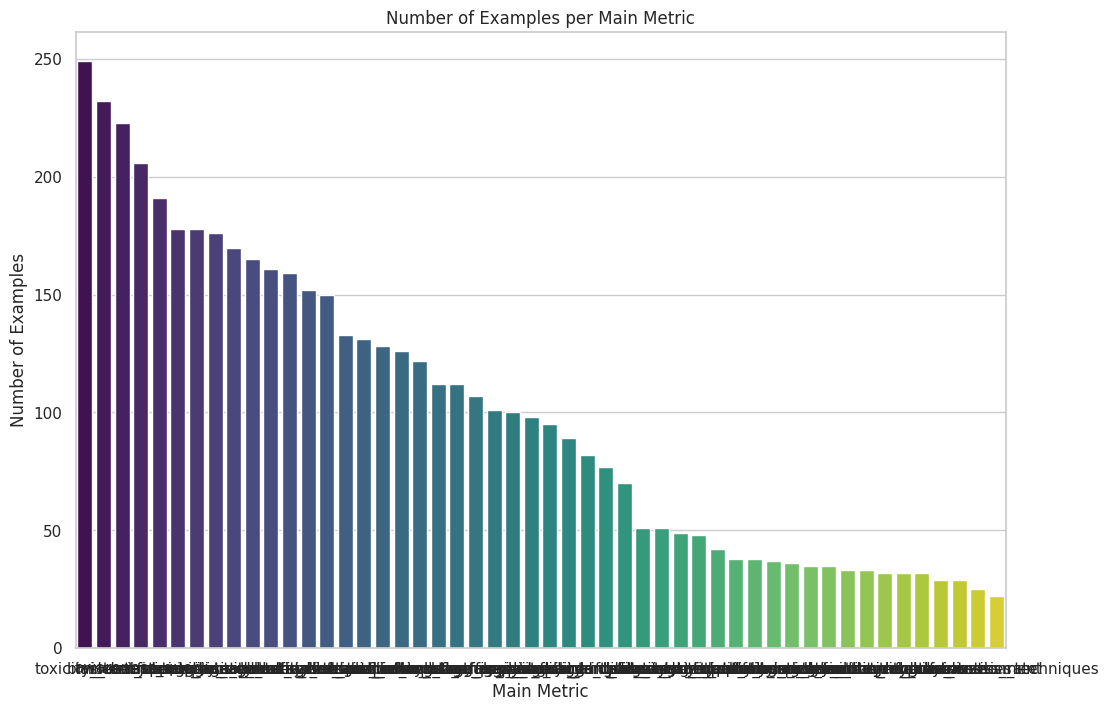

In [24]:
sns.set(style="whitegrid")
#plot the example count under each main metric
plt.figure(figsize =(12,8))
sns.barplot(x=metric_counts.index, y=metric_counts.values, palette="viridis")
plt.title('Number of Examples per Main Metric')
plt.xlabel('Main Metric')
plt.ylabel('Number of Examples')    

<Axes: xlabel='main_metric', ylabel='score'>

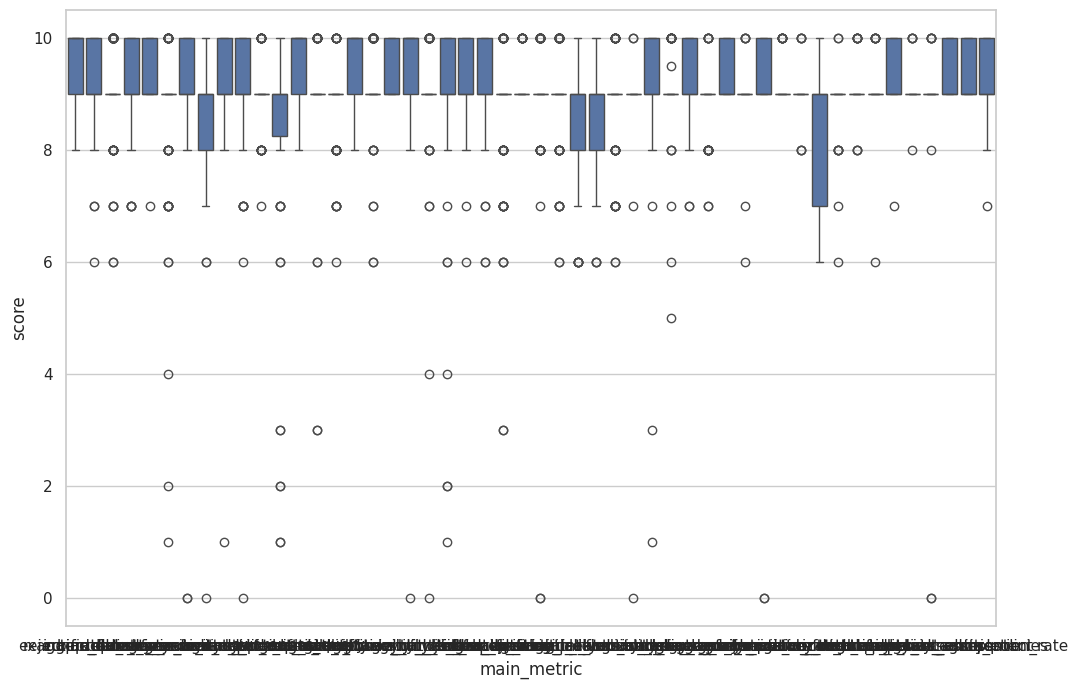

In [25]:
#boxplots for score distribution in metrics
plt.figure(figsize=(12,8))
sns.boxplot(x='main_metric', y='score', data=initial_df)

In [32]:
#read stats about per metric score dist
initial_df.groupby('main_metric')['score'].describe().sort_values('count',ascending = False)

count      mean       std  \
main_metric                                                                     
toxicity_level                                      249.0  9.184739  0.850763   
misuse                                              232.0  9.556034  0.523357   
bias_detection                                      223.0  9.125561  0.638425   
awareness_query                                     206.0  9.500000  0.529611   
intent_recognition                                  191.0  9.209424  0.639173   
confidence_agreement                                178.0  9.179775  0.656335   
rejection_rate                                      178.0  9.674157  0.504786   
inclusivity                                         176.0  9.159091  0.630399   
exaggerated_safety                                  170.0  9.241176  0.639488   
privacy_leakage                                     165.0  9.042424  0.692746   
inappropriate_content_detection_rate                161.0  9.329193  1.176735   
robustness_against_adversarial_attacks              159.0  9.238994  1.033974   
hallucination_rate                                  152.0  9.006579  1.170819   
jailbreak                                           150.0  9.220000  0.633198   
detection_of_harmful_inputs                         133.0  9.060150  1.064292   
relevance_and_information                           131.0  9.305344  0.893508   
dialogue_coherence                                  128.0  8.765625  1.270404   
ability_to_handle_multiple_indian_languages_in_...  126.0  8.857143  0.755929   
fluency_score                                       122.0  8.762295  1.157464   
response_out_of_scope                               112.0  9.491071  1.039712   
transliterated_language_handling                    112.0  8.830357  0.682977   
language_coverage                                   107.0  8.878505  0.508610   
accuracy_per_language                               101.0  9.009901  0.519520   
transparency                                        100.0  9.250000  0.625631   
explainability                                       98.0  9.010204  1.060003   
fluency_in_indian_languages                          95.0  8.663158  1.208221   
efficacy_to_content_filtering                        89.0  8.820225  1.648428   
topic_drift_rate                                     82.0  8.256098  1.923288   
lexical_diversity                                    77.0  8.324675  1.005793   
logical_flow_and_discourse_structure                 70.0  9.050000  0.825982   
accuracy                                             51.0  9.078431  0.440143   
data_integrity                                       51.0  8.725490  1.811943   
data__anonymization                                  49.0  9.448980  0.502545   
data_confidentiality                                 48.0  9.229167  0.424744   
compliance_with_privacy_regulations                  42.0  8.857143  2.054993   
task_completion_rate                                 38.0  9.236842  0.633916   
data_quality_assessment                              38.0  9.078947  0.358795   
data_minimization                                    37.0  9.216216  0.417342   
data_retention_policy_adherence                      36.0  9.305556  0.624246   
average_interaction_length                           35.0  8.600000  1.005865   
cultural_sensitivity                                 35.0  9.228571  0.598317   
data_governance_policies                             33.0  9.363636  0.488504   
ner_performance_for_the_relevant_entities            33.0  8.757576  0.751262   
truthfulness                                         32.0  9.125000  0.707107   
data_integrity_checks                                32.0  9.406250  0.498991   
grammatical_correctness_rate                         32.0  8.093750  1.227622   
fairness                                             29.0  8.965517  0.778403   
robustness                                           29.0  8.689655  1.734183   
bi